# 1. Load libraries and create some functions

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.models import Model
from tensorflow.keras.models import load_model
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [4]:
def get_model_metrics(test_data, model, model_name, clf_threshold):
    '''''''''
    Get binary classification metrics for a given model and saves the results to local directory
    '''''''''
    # Generate a timestamp for the current run
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    # Create the 'results' folder if it doesn't exist
    results_folder = 'results'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    # 1. Get predicted and true labels
    predicted_probs = []  # Store raw probabilities here
    true_labels = []
    predicted_labels = []

    for images, labels in test_data:
        # Generate predictions using the model
        predictions = model.predict(images, verbose=0)

        # Store the raw probabilities
        predicted_probs.extend(predictions.flatten())

        # Convert the predicted probabilities to binary labels (0 or 1)
        predicted_labels.extend([1 if p > clf_threshold else 0 for p in predictions])

        # Convert true labels to binary labels (0 or 1)
        true_labels.extend([int(label) for label in labels])

    # 2. Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()

    # 3. Calculate precision, recall, and F1-score
    report = classification_report(true_labels, predicted_labels)
    print(report)
    
    with open(f'{results_folder}/{model_name}_run_{timestamp}_classification_report.txt', 'w') as report_file:
        report_file.write(report)

    # 4. Calculate ROC AUC and plot the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [5]:
def build_model_brains(base_model, transfer_learning): 
    '''''''''
    Creates a model that takes grayscale images as input, and freezes all the layers of a base model except for the last four.
    Additionaly, 3 custom layers (+1 for prediction) are created
    '''''''''
    # Set the base_model to be non-trainable initially
    base_model.trainable = False

    # If transfer_learning is 'N', make the entire base_model trainable
    if transfer_learning == 'N':
        base_model.trainable = True
    elif transfer_learning == 'Y':
        # Make only the last 4 layers of the base_model trainable
        for layer in base_model.layers[-4:]:
            layer.trainable = True

    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the base_model
    x = base_model(x)

    # Add own top layers for classification
    x = Flatten()(x)
    x = Dense(50, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model


In [7]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# 2. Load data

In [8]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/brain-data/train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['not_brain', 'brain']  # Assign class 0 to not_brain and class 1 to brain                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/brain-data/validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['not_brain', 'brain']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/brain-data/test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['not_brain', 'brain']
)

Found 9005 files belonging to 2 classes.
Found 1620 files belonging to 2 classes.
Found 1775 files belonging to 2 classes.


# 3. Class Weights

In [44]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for _, label in train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
# class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))
class_weights_dict = {int(key): value for key, value in class_weights_dict.items()}
class_weights_dict

{0: 0.24686285397001662, 1: 0.7531371460299834}

# 4. VGG16 TL

1. Train a binary classifier on ultrasound images to classify brain vs not brain, based on VGG16 architecture. All layers are frozen except for the last 4 layers (new weights will be calculated based on the ultrasound images), and 4 additional custom layers are added. The weights will be saved.

2. Create the same model architechture in order to train the placental ultrasound images. The weights from the previous model will be loaded, so the model has base layers with weights from Imagenet, then 4 layers with weights fine tuned by the brain classifier, and then 4 layers to fine tune the placenta images.

In [46]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## 4.1. Train Brains Classifier

In [13]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

train_data_rgb = train_data.map(convert_to_rgb)
val_data_rgb = val_data.map(convert_to_rgb)
test_data_rgb = test_data.map(convert_to_rgb)

prep_train_data = train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_val_data = val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_test_data = test_data_rgb.map(lambda x, y: (preprocess_input(x), y))


def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply the conversion
prep_train_data = prep_train_data.map(convert_to_grayscale)
prep_val_data = prep_val_data.map(convert_to_grayscale)
prep_test_data = prep_test_data.map(convert_to_grayscale)


In [23]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_VGG16 = build_model_brains(base_model=base_model_VGG16, transfer_learning='Y')

# Model summary
model_VGG16.summary()

base_model.trainable set to False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 50)                1254450   
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                           

In [24]:
# Compilación de la red
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

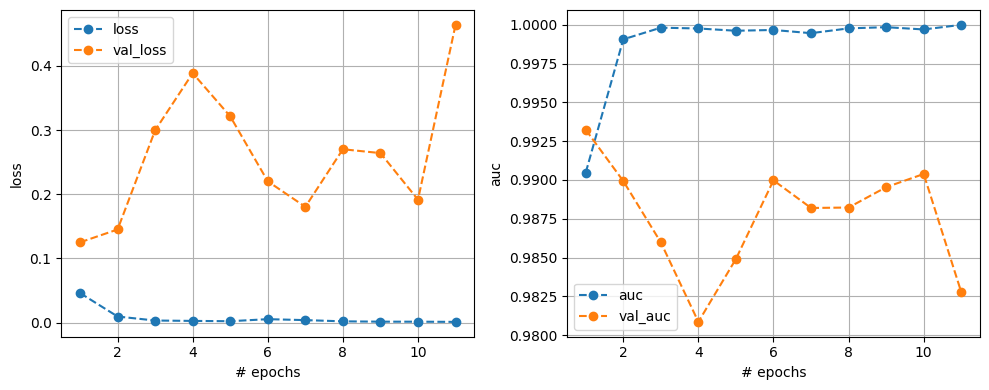

282/282 [==============================] - 49s 171ms/step - loss: 0.0010 - auc: 1.0000 - val_loss: 0.4639 - val_auc: 0.9828
Training time: 658.3498287200928 seconds


In [25]:
# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(prep_train_data,
                    epochs=15, #150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

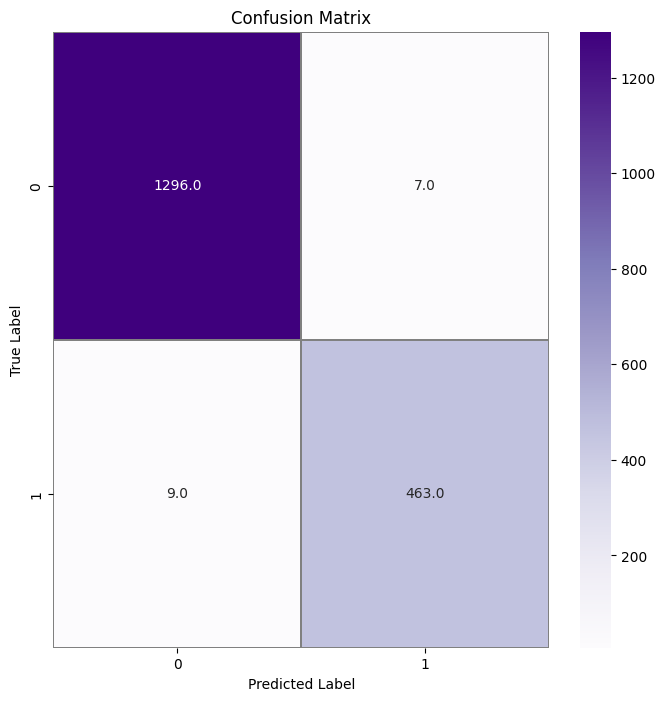

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1303
           1       0.99      0.98      0.98       472

    accuracy                           0.99      1775
   macro avg       0.99      0.99      0.99      1775
weighted avg       0.99      0.99      0.99      1775



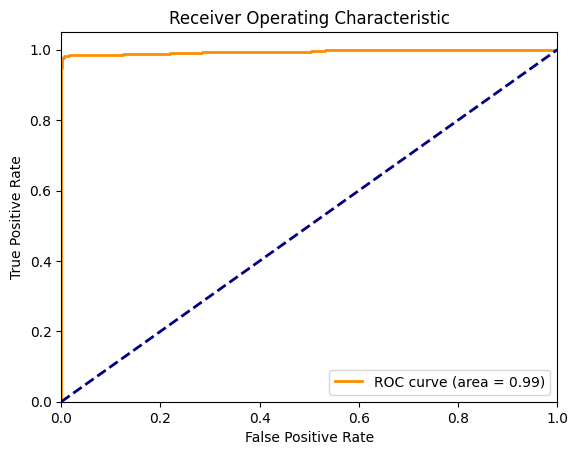

In [26]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG_TL', clf_threshold=0.5)

# 4B. VGG16 NO Transfer Learning

## 4B.1. Train Brains Classifier

In [41]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_VGG16 = build_model_brains(base_model=base_model_VGG16, transfer_learning='N')

# Compilación de la red
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


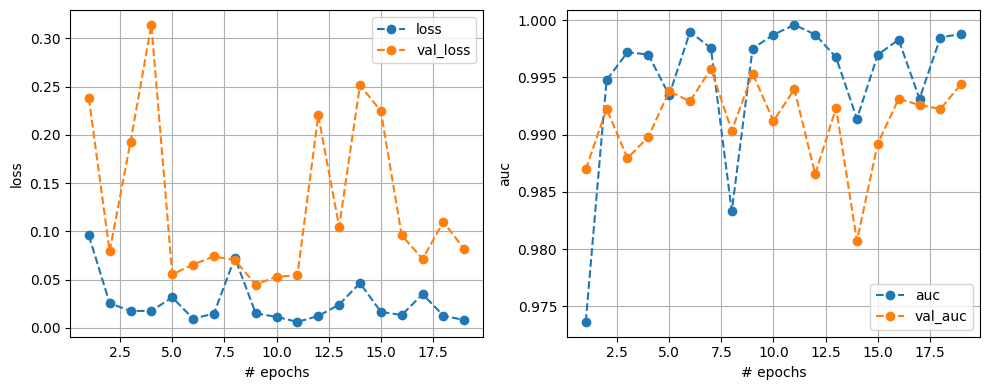

282/282 [==============================] - 65s 229ms/step - loss: 0.0080 - auc: 0.9988 - val_loss: 0.0814 - val_auc: 0.9944
Training time: 1303.0480334758759 seconds


In [42]:
# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_notl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(prep_train_data,
                    epochs=150, #now 150 instead of 15 to allow for better learning from scratch
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

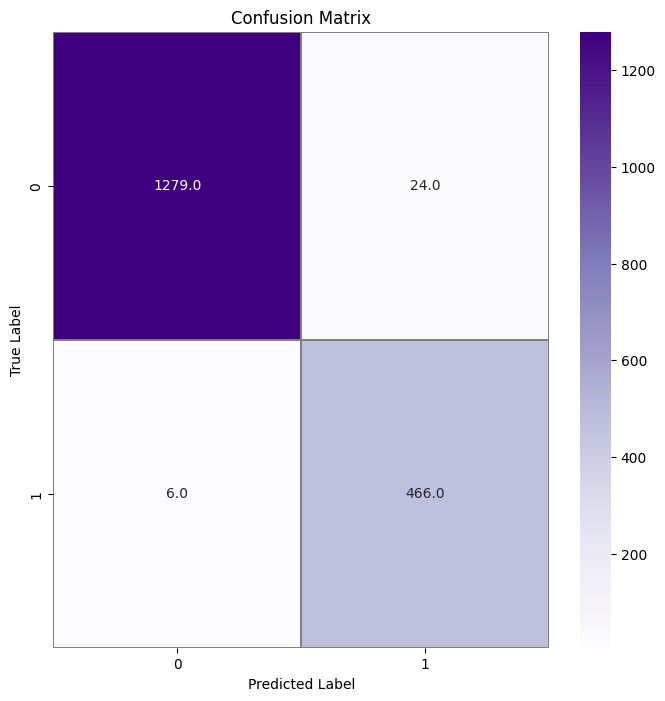

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1303
           1       0.95      0.99      0.97       472

    accuracy                           0.98      1775
   macro avg       0.97      0.98      0.98      1775
weighted avg       0.98      0.98      0.98      1775



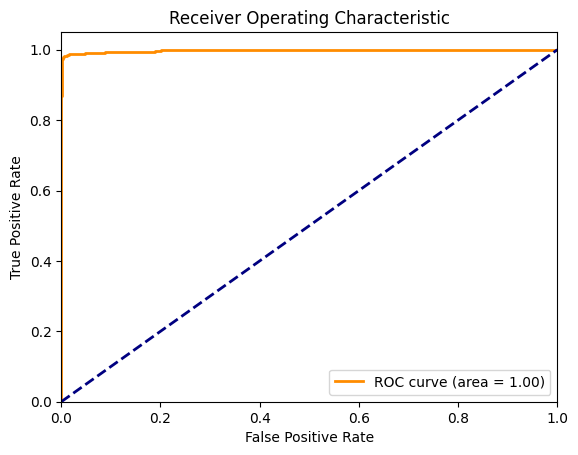

In [43]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG_TL', clf_threshold=0.5)

# 5. ResNet18 TL

In [49]:
!pip install image-classifiers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [50]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

## 5.1. Train Brains Classifier

In [59]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [60]:
model_resnet18 = build_model_brains(base_model=base_resnet18, transfer_learning='Y')

base_model.trainable set to False


In [61]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

prep_train_data = train_data.map(preprocess_data_resnet18)
prep_val_data = val_data.map(preprocess_data_resnet18)
prep_test_data = test_data.map(preprocess_data_resnet18)

In [62]:
# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

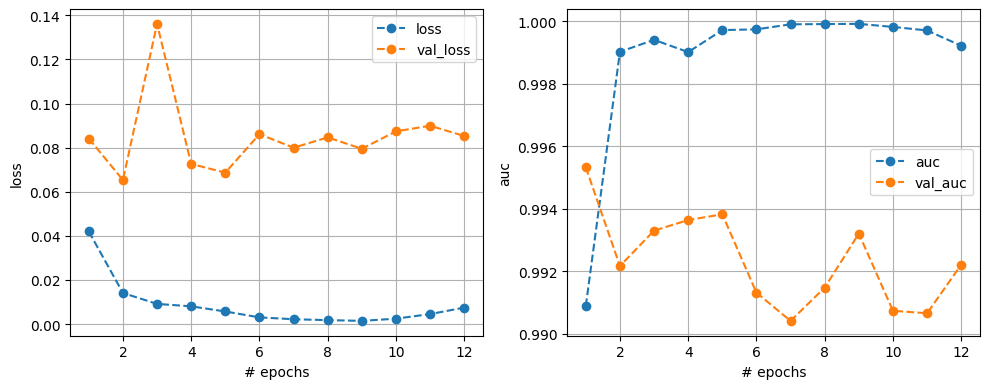

282/282 [==============================] - 33s 114ms/step - loss: 0.0075 - auc: 0.9992 - val_loss: 0.0853 - val_auc: 0.9922


In [63]:
# Entrenamiento de la red
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(prep_train_data,
                    epochs=15,
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=class_weights_dict
                    )

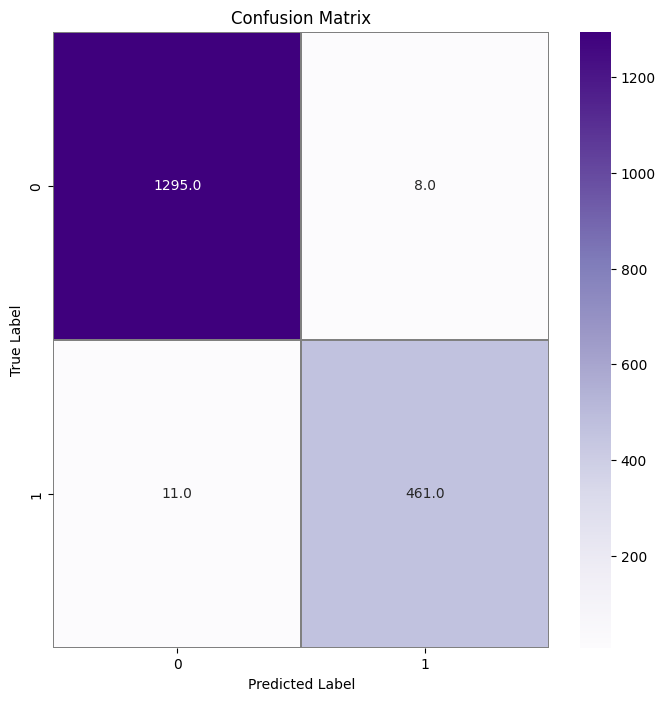

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1303
           1       0.98      0.98      0.98       472

    accuracy                           0.99      1775
   macro avg       0.99      0.99      0.99      1775
weighted avg       0.99      0.99      0.99      1775



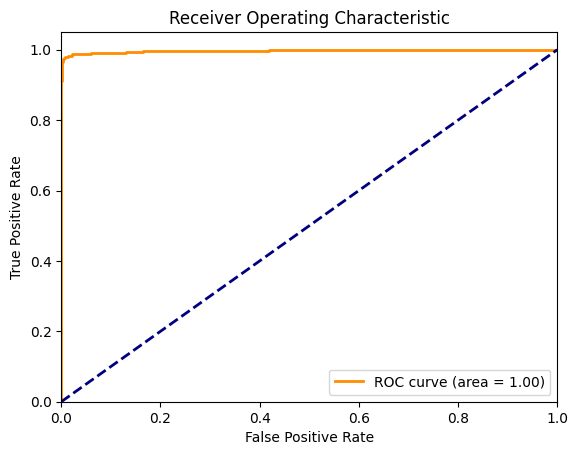

In [64]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18_Brain', clf_threshold=0.5)

# 5B. ResNet18 NO TL

In [75]:
!pip install image-classifiers

In [76]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

## 5B.1. Train Brains Classifier

In [77]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model_brains(base_model=base_resnet18, transfer_learning='N')

base_model.trainable set to True


In [78]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

prep_train_data = train_data.map(preprocess_data_resnet18)
prep_val_data = val_data.map(preprocess_data_resnet18)
prep_test_data = test_data.map(preprocess_data_resnet18)

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

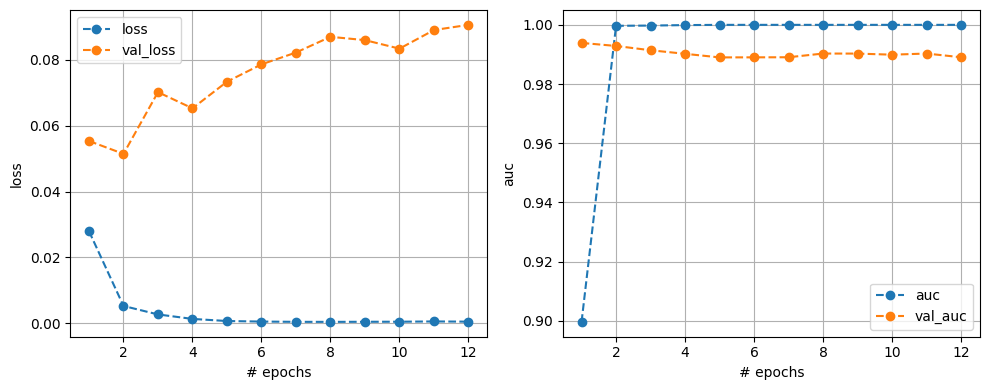

282/282 [==============================] - 33s 116ms/step - loss: 5.0889e-04 - auc: 1.0000 - val_loss: 0.0907 - val_auc: 0.9890


In [79]:
# Entrenamiento de la red
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_noTL_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(prep_train_data,
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=class_weights_dict
                    )

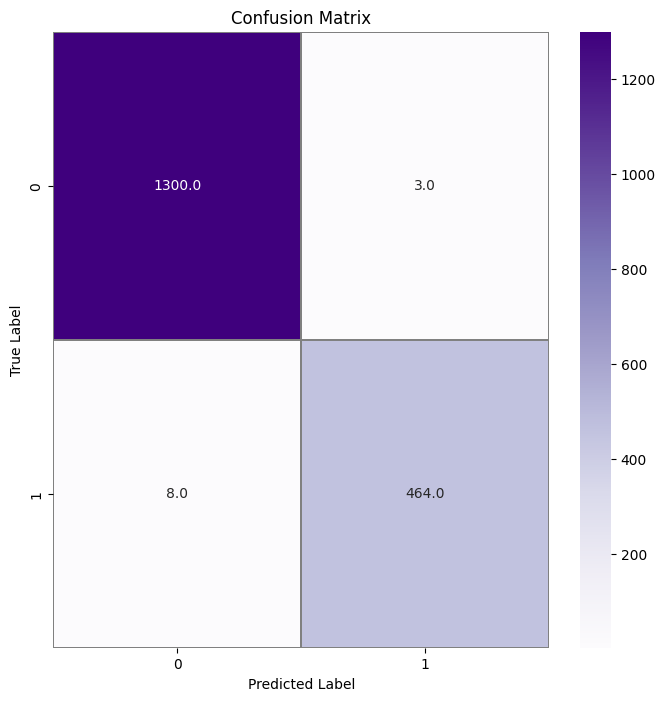

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1303
           1       0.99      0.98      0.99       472

    accuracy                           0.99      1775
   macro avg       0.99      0.99      0.99      1775
weighted avg       0.99      0.99      0.99      1775



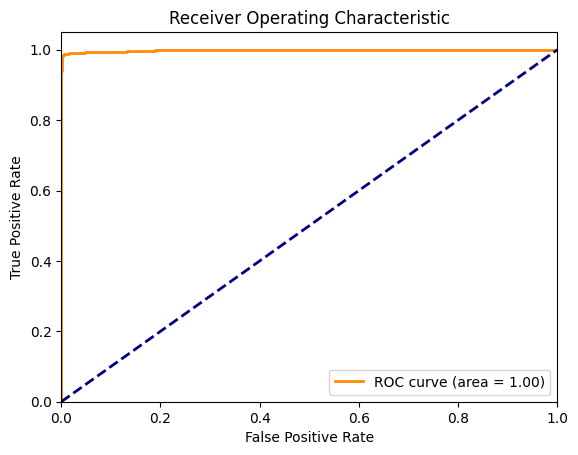

In [80]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18_Brain', clf_threshold=0.5)